### Exercício 01

(a) Crie uma função (em Python) que seja capaz de reduzir e/ou aumentar a resolução
espacial de uma imagem por um fator n, que é um número real positivo (n>1 para um
aumento da resolução espacial e n< 1 para uma redução da resolução espacial). Tal
função deve possuir como parâmetros de entrada, o nome do arquivo da imagem para
leitua no disco e o fator n. Para aumento da resolução utilize a técnica do **vizinho-mais-próximo** vista em sala de aula.

In [23]:
import numpy as np
import cv2
from cv2 import imread
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
img_folder = 'imagens/'

In [24]:
def show_img(img, title='image'):
    img = img[:, :, ::-1]
    plt.imshow(img)
    plt.title(title)
    plt.axis(False)
    plt.show()

In [3]:
def interpolate_neighbors_loop(size_new, row_positions, col_positions, img):
    img_resized = np.empty((size_new[0], size_new[1], 3), dtype=np.uint8)

    for i in range(len(row_positions)):
        for j in range(len(col_positions)):
            img_resized[i][j] = img[row_positions[i]][col_positions[j]]

    return img_resized

In [5]:
def interpolate_neighbors_vectorized(row_positions, col_positions, img):
    return img[row_positions, :][:, col_positions]

In [6]:
def interpolate_neighbors(img, size_new, fator, method='vectorized'):
    row_positions = (np.ceil((np.arange(size_new[0]) + 1) / fator) - 1).astype(int)
    col_positions = (np.ceil((np.arange(size_new[1]) + 1) / fator) - 1).astype(int)

    if method == 'vectorized':
        return interpolate_neighbors_vectorized(row_positions, col_positions, img)
    elif method == 'loop':
        return interpolate_neighbors_loop(size_new, row_positions, col_positions, img)
    else:
        print('Método não disponível')
        return

In [7]:
def mudanca_resolucao(img, fator, method='vizinho'):
    size_original = np.array(img.shape[:2])
    size_new = (size_original * fator).astype(int)

    img_resized = None

    if method == 'vizinho':
        img_resized = interpolate_neighbors(img, size_new, fator)
    elif method == 'bilinear':
        img_resized = interpolate_bilinear(img, size_new, fator)
    else:
        print('Método não disponível')
        pass

    return img_resized

In [8]:
def mudanca_resolucao_path(img_path, fator, method='vizinho'):
    img = imread(img_path)

    return mudanca_resolucao(img, fator, method)

(b) Utilize o sua função do item anterior para gerar imagens com resolução espacial
**reduzida** por fatores de 2, 4, 8 e 16. Em seguida, utilize o seu programa novamente para
aumentar estas imagens de volta ao seu tamanho original. Há diferenças de qualidade
entre estas imagens? Comente. (Obs.: Plote os resultados para que possam se
visualizados).

In [10]:
fatores = [2, 4, 8, 16]
img_path = img_folder + 'lenna.png'

Tamanho original da imagem (512, 512)


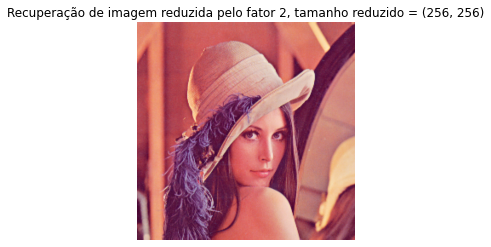

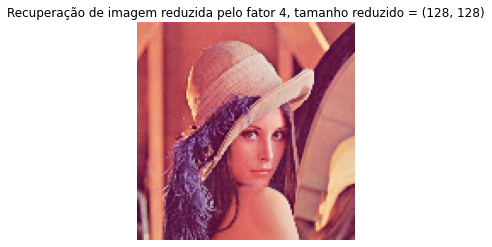

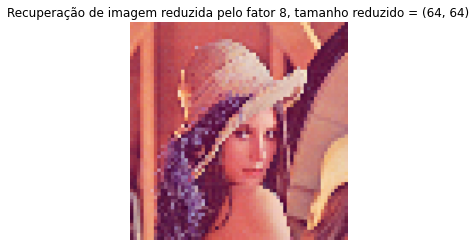

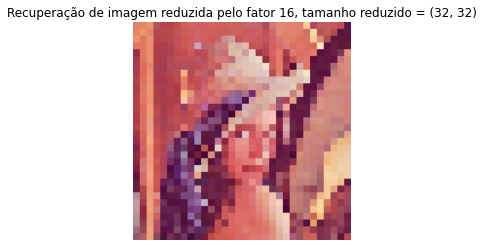

In [33]:
img_reduzidas = []

print(f'Tamanho original da imagem {imread(img_path).shape[:2]}')

for fator in fatores:
    fator = 1/fator
    img_reduzidas.append(mudanca_resolucao_path(img_path, fator, 'vizinho'))

for fator, img in zip(fatores, img_reduzidas):
    img_aumentada = mudanca_resolucao(img, fator, 'vizinho')
    show_img(img_aumentada, title=f'Recuperação de imagem reduzida pelo fator {fator}, tamanho reduzido = {img.shape[:2]}')


(c) Modifique a função desenvolvida em (a), de forma que seja utilizada a técnica de
**interpolação bilinear** e refaça o que se pede no item (b) novamente. (Obs.: Plote os
resultados para que possam se visualizados).

In [31]:
def interpolate_bilinear(img, size_new, fator):
    img_resized = np.empty((size_new[0], size_new[1], 3), dtype=np.uint8)

    for row in range(size_new[0]):
        for col in range(size_new[1]):
            x_new = (1/fator) * col
            y_new = (1/fator) * row

            x1 = np.floor(x_new).astype(int)
            y1 = np.floor(y_new).astype(int)
            x2 = np.ceil(x_new).astype(int)
            y2 = np.ceil(y_new).astype(int)

            #limite final das posições da imagem
            if x2 == img.shape[:2][0]:
                x2 -= 1
            if y2 == img.shape[:2][1]:
                y2 -= 1

            dx = x_new - x1
            dy = y_new - y1

            A = img[y1][x1]
            B = img[y1][x2]
            C = img[y2][x1]
            D = img[y2][x2]

            px1 = (1 - dx) * (1 - dy) * A
            px2 = dx * (1 - dy) * B
            px3 = (1 - dx) * dy * C
            px4 = dx * dy * D

            img_resized[row][col] = px1 + px2 + px3 + px4

    return img_resized

Tamanho original da imagem (512, 512)


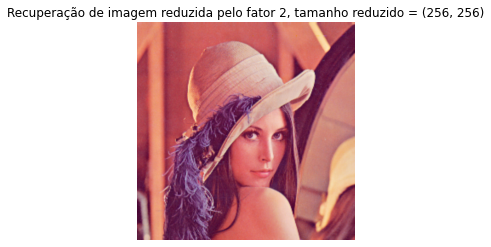

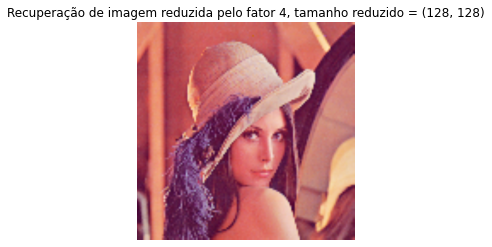

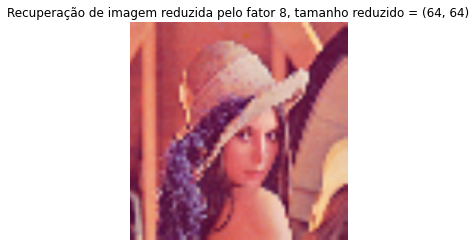

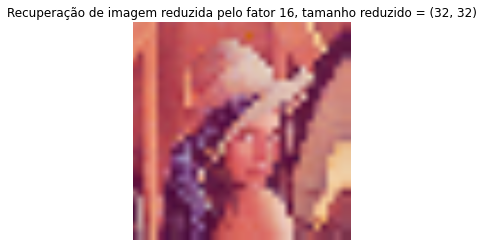

In [34]:
img_reduzidas = []

print(f'Tamanho original da imagem {imread(img_path).shape[:2]}')

for fator in fatores:
    fator = 1/fator
    img_reduzidas.append(mudanca_resolucao_path(img_path, fator, 'bilinear'))

for fator, img in zip(fatores, img_reduzidas):
    img_aumentada = mudanca_resolucao(img, fator, 'bilinear')
    show_img(img_aumentada, title=f'Recuperação de imagem reduzida pelo fator {fator}, tamanho reduzido = {img.shape[:2]}')

### Exercício 02

(a) Escreva uma função que realize a filtragem espacial de uma imagem. Essa função
terá 2 parâmetros de entrada: a imagem a ser transformada e o filtro a ser utilizado.

(b) Aplique os filtros abaixo na imagem da Lena (que foi enviada com o trabalho).
Compare os resultados obtidos para cada um dos filtros. Com base nestes resultados,
qual o tipo de filtro (passa-alta, passa-baixa, passa-faixa, etc.) que está sendo utilizado
em cada caso e qual o efeito de cada filtro na imagem.

(c) O filtro 1 possui tamanho 3x3. O que aconteceria se aumentássemos o tamanho do
filtro para 11x11, 17x17 ou 35x35? De que forma o tamanho do filtro afeta a imagem?

### Exercício 03

(a)Converta os filtros h1 e h2 para o domínio da frequência. Visualize o **módulo** de cada
filtro. Obs: Para visualizar melhor a resposta do filtro no domínio da frequência **desloque
a frequência (0,0) para o centro da imagem.**

(b) Filtre, no domínio da frequência, três imagens (diferentes e de sua escolha) com cada
um dos dois filtros. Em seguida, calcule a transformada inversa. O resultado da **filtragem
espacial** (use a função implementada na segunda questão para verificar o resultado da
filtragem espacial) é o mesmo da **filtragem no domínio da frequência**? Justifique.

### Exercício 04

(a) Tire a transformada das imagens **noiseball.png** e **footBallOrig.png** (enviadas juntas
com a atividade). Visualize o módulo (ou magnitude) destas transformadas. Há alguma
diferença? É possível recuperar a imagem **noiseball.png** e eliminar o ruído? Justifique
sua resposta.

(b) Calcule a transformada inversa da imagem filtrada e visualize o resultado. Comente.